In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import scipy, random, copy, h5py, pandas, math, csv, sys, os, pickle, re, json, warnings
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn import preprocessing
from numpy.random import RandomState
from scipy import ndimage
from scipy import stats
from scipy import ndimage
from datetime import datetime
path = os.getcwd()

sub_routines = os.path.join(path,'..','QueVasaEstudiar','python', 'sub_routines')
sys.path.append(sub_routines)
from neural_predictor import neural_predictor
from Import_MenuParameters import Import_MenuParameters
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

gcolor = '#e6550d'

In [2]:
root = os.path.join(path,'..')

csv_path = root + "/Bots_Colombia/data/"

def loadOutcomes():
    outcomes = {}
    with open(root + '/QueVasaEstudiar/python/Options_Outcomes_05_15_2018.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            outcomes[int(row['Option_ID'])] = row
    return outcomes

outcomes = loadOutcomes()

def arange_outcomes(outcomes):

    HEOptions = {
    'MajorName'       : np.array([outcomes[x]['Option_Major_Name'] for x in outcomes.keys()]),
    'OptionID'        : np.array([x for x in outcomes.keys()]).astype(int),
    'InstCode'        : np.array([outcomes[x]['Option_Institution_Code'] for x in outcomes.keys()]).astype(int) -1,
    'Cutoff'          : np.array([outcomes[x]['LowerBoundScore'] for x in outcomes.keys()]).astype(float),
    'NoSearch'        : np.array([outcomes[x]['NoSearch'] for x in outcomes.keys()]).astype(int),
    'LevelCode'       : np.array([outcomes[x]['Option_Level_Code'] for x in outcomes.keys()]).astype(int) -1,
    'AreaCode'        : np.array([outcomes[x]['Option_Area_Code'] for x in outcomes.keys()]).astype(int) -1,
    'LocationCode'    : np.array([outcomes[x]['Option_Location_Code'] for x in outcomes.keys()]).astype(int) -1,
    'MajorCode'       : np.array([outcomes[x]['Option_Major_Code'] for x in outcomes.keys()]).astype(int) -1,
    'AverageEarning'  : np.array([outcomes[x]['Outcome_IncomeAve'] if outcomes[x]['Outcome_IncomeAve'] != "" else "-999" for x in outcomes.keys()]).astype(float)
    }

    HEOptions['AreaID']     = np.array(list(set(HEOptions['AreaCode'])))
    HEOptions['InstID']     = np.array(list(set(HEOptions['InstCode'])))      #We have to change this part
    HEOptions['LevelID']    = np.array(list(set(HEOptions['LevelCode'])))
    HEOptions['LocationID'] = np.array(list(set(HEOptions['LocationCode'])))
    HEOptions['MajorID']    = np.array(list(set(HEOptions['MajorCode'])))

    #Fixes:
    aux_InstID = np.array(range(HEOptions['InstID'].shape[0]))

    for y in HEOptions:
        HEOptions[y] = HEOptions[y][:,np.newaxis]

    for i in range(HEOptions['InstID'].shape[0]):
        HEOptions['InstCode'][HEOptions['InstCode'] == HEOptions['InstID'][i,0]] = aux_InstID[i]

    HEOptions['RelevantInst']  = aux_InstID[:,np.newaxis]
    HEOptions['normW']         = 10000000
    HEOptions['AverageEarning'][HEOptions['AverageEarning'] == -999] = np.nan

    return HEOptions

#1. SET UP AND IMPORT DATA:
#==========================

#1.1. IMPORT DATA ABOUT OPTIONS:
HEOptions = arange_outcomes(outcomes)


#1.3. IMPORT DATA ABOUT ALL INTERACTIONS:
allinteractions = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/allinteractions.csv', error_bad_lines=False)
allinteractions = allinteractions[(allinteractions.user != 'default-user') & (allinteractions.user.str.len() == 20)].reset_index(drop=True)
allinteractions["year"] = allinteractions.timestamp.str[0:4].astype(int)
allinteractions["month"] = allinteractions.timestamp.str[5:7].astype(int)
allinteractions["day"] = allinteractions.timestamp.str[8:10].astype(int)
allinteractions["second"] = allinteractions.timestamp.str[17:19].astype(int)
allinteractions["minute"] = allinteractions.timestamp.str[14:16].astype(int)
allinteractions["hour"] = allinteractions.timestamp.str[11:13].astype(int) - 7
allinteractions["hour"][allinteractions["hour"]==-7] = 17
allinteractions["hour"][allinteractions["hour"]==-6] = 18
allinteractions["hour"][allinteractions["hour"]==-5] = 19
allinteractions["hour"][allinteractions["hour"]==-4] = 20
allinteractions["hour"][allinteractions["hour"]==-3] = 21
allinteractions["hour"][allinteractions["hour"]==-2] = 22
allinteractions["hour"][allinteractions["hour"]==-1] = 23

allinteractions = allinteractions[(allinteractions.year == 2018) & (allinteractions.month >= 9)]
allinteractions = allinteractions[(allinteractions.user != "992") & (allinteractions.user != "YBOF9JBM8DE9ME6RE1K4") & (allinteractions.user != "EMF393CY0PX7ESW0BNQ")]
allinteractions = allinteractions.sort_values(['month','day'])
allinteractions['Cummulative'] = np.cumsum(np.ones((allinteractions.shape[0],1))).astype(int)
allinteractions['Interacted'] = 1
allinteractions['times'] = list(map(lambda x: x[0:10] + " " + x[11:19], allinteractions['timestamp']))
allinteractions['times'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), allinteractions['times']))
allinteractions['hours'] = list(map(lambda x: x[0:10] + " " + x[11:13], allinteractions['timestamp']))
allinteractions['hours'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H'), allinteractions['hours']))
allinteractions['days'] = list(map(lambda x: x[0:10] , allinteractions['timestamp']))
allinteractions['days'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), allinteractions['days']))


#1.3. IMPORT DATA ABOUT WAGE DEVIATIONS:
wageDeviation   = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/wage_deviation.csv'.format(100)).drop(columns = ['Unnamed: 0']).rename(columns= {'studentID': 'user'})
wageDeviation['hours'] = list(map(lambda x: x[0:10] + " " + x[11:13], wageDeviation['time']))
wageDeviation['hours'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H'), wageDeviation['hours']))
wageDeviation['times'] = list(map(lambda x: x[0:10] + " " + x[11:19], wageDeviation['time']))
wageDeviation['times'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), wageDeviation['times']))
wageDeviation['days'] = list(map(lambda x: x[0:10] , wageDeviation['time']))
wageDeviation['days'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), wageDeviation['days']))
wageDeviation['interaction'] = 1
wageDeviation['absWageDeviation'] = list(map(lambda x: abs(x), wageDeviation['wageDeviation']))

i = 1
j = 0
wageDeviation = wageDeviation.sort_values(by = ['user', 'times'])
wageDeviation['numberMenu'] = -999
for i in range(1,wageDeviation.shape[0]):
    if wageDeviation['user'].iloc[i] == wageDeviation['user'].iloc[i-1]:
        j += 1
        wageDeviation['numberMenu'].iloc[i] = j
    else:
        j = 1
        wageDeviation['numberMenu'].iloc[i] = j

wageDeviation['numberMenu'].iloc[0]=1
wageDeviation['numberMenu'][wageDeviation['numberMenu'] == 8] = 8
wageDeviation['numberMenu'][wageDeviation['numberMenu'] == 9] = 8
wageDeviation['numberMenu'][wageDeviation['numberMenu']>=10] = 9
wageDeviation['N_total']=1

wageDeviation['Max_interaction'] = ""
wageDeviation = wageDeviation.merge(wageDeviation.groupby(['user']).sum().reset_index()[['user', 'interaction']].rename(columns ={'interaction':'max_interaction'}), left_on = 'user', right_on = 'user')
wageDeviation['Max_interaction'][(wageDeviation['max_interaction'] > 0) & (wageDeviation['max_interaction'] <= 3)] = ']0-3]'
wageDeviation['Max_interaction'][(wageDeviation['max_interaction'] > 3) & (wageDeviation['max_interaction'] <= 6)] = ']3-6]'
wageDeviation['Max_interaction'][(wageDeviation['max_interaction'] > 6) & (wageDeviation['max_interaction'] <= 9)] = ']6-9]'
wageDeviation['Max_interaction'][wageDeviation['max_interaction'] >= 9] = ']9-inf]'

#1. Data for performance of the Structural and ML model:
#======================================================

parameters = {}
path_pickle = os.path.join(path, '..', 'Bots_Colombia', 'ModelEstimation','deeplearning_estimation', '')
with open(path_pickle + 'parameters_nn.pickle', 'rb') as handle:
    parameters['NN'] = pickle.load(handle)

studentFeatures = pd.read_csv(root+'/QueVasaEstudiar/Student_Features_Fall2018.csv'.format(100))
interactionsBot = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/interactions_bot.csv'.format(100))
seedAssignment  = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/seeds_intervention.csv').drop(columns=['Unnamed: 0'])
interactions    = seedAssignment.merge(studentFeatures, left_on = 'url_id', right_on = 'url_id', how = 'left')
interactions    = interactions.merge(interactionsBot, left_on = 'Student_ID', right_on = 'Student_ID', how = 'inner')

n_int = interactions.shape[0]
n_options = HEOptions['MajorName'].shape[0]

#2.2. Generate tags
dpto_code = list(set(studentFeatures['Student_Location_Code']))

for x in dpto_code:
    interactions['dpto_'+str(x)] = (interactions['Student_Location_Code'] == x).astype(int)
    dpto_tag = ['dpto_'+str(x) for x in dpto_code]

menu_tag = ['Menu1','Menu2','Menu3','Menu4']
tag_continuous = ['punt_rez_sede','inse_rez_sede','puntsd_rez_sede', 'insesd_rez_sede', 'edad']

X_indexslates = np.array(interactions[menu_tag])
for i,j in zip(range(n_options), list(HEOptions['OptionID'][:,0])):
    X_indexslates[:,0][X_indexslates[:,0]==j] = i
    X_indexslates[:,1][X_indexslates[:,1]==j] = i
    X_indexslates[:,2][X_indexslates[:,2]==j] = i
    X_indexslates[:,3][X_indexslates[:,3]==j] = i

X_SlateEarnigs          = HEOptions['AverageEarning'][X_indexslates].reshape(n_int,len(menu_tag))
X_SlateEarnigs[np.isnan(X_SlateEarnigs)] = np.nanmean(X_SlateEarnigs)
X_SlateEarnigs          = X_SlateEarnigs
X_SlateLevels           = HEOptions['LevelCode'][X_indexslates].reshape(n_int,len(menu_tag))
X_SlateInst             = HEOptions['InstCode'][X_indexslates].reshape(n_int,len(menu_tag))
X_SlateArea             = HEOptions['AreaCode'][X_indexslates].reshape(n_int,len(menu_tag))
X_Score                 = np.array(interactions['Student_Score']).reshape(n_int,1)
X_ScoreDecil            = np.array(interactions['Student_ScoreDecil']).reshape(n_int,1)
X_Continuous            = np.array(interactions[tag_continuous]).reshape(n_int,len(tag_continuous)).astype(int)
X_Gender                = np.array(interactions['Student_Gender']).reshape(n_int,1)
X_LocationCode          = np.array(interactions[dpto_tag]).reshape(n_int,len(dpto_tag)).astype(int)

X                       = np.hstack((X_SlateEarnigs,X_SlateLevels,X_SlateInst,X_SlateArea,X_Gender,X_Score,X_ScoreDecil,X_LocationCode,X_Continuous))
Y                       = np.array(interactions['Selection']).reshape(n_int, 1) == np.concatenate((np.array(interactions[['Menu1','Menu2','Menu3','Menu4']]), np.array([-999]*n_int).reshape(n_int,1)), axis =  1)

X                       = (X - parameters['NN']['X_mean'])/parameters['NN']['X_std']


ClickProb, _ = neural_predictor(X.T, parameters['NN'], 'NN', None, None)
Y_hat = ClickProb.T == ClickProb.T.max(1).reshape(n_int,1)

#2. How does the neural network perform on the data provided by the different treatment arms??

#2.1. Accuracy
Accuracy = (Y * Y_hat).sum(1).reshape(n_int,1)

#2.2. Probability
Pr = (ClickProb.T * (Y * Y_hat)).sum(1).reshape(n_int,1)

#2.3. Expected Value:
Pr_dist = ClickProb.T[:,:-1]/ClickProb.T[:,:-1].sum(1).reshape(n_int,1)
EV = (X_SlateEarnigs*Pr_dist).sum(1).reshape(n_int,1)/10**7

#3. Compute cool graphics:
#3.1 Create DataFrame that allows us to create cool graphics:
TreatmentArm = np.array(interactions['bot']).reshape(n_int,1)
NeuralNet_DataFrame = pd.DataFrame(np.hstack((TreatmentArm, Accuracy, Pr, EV)), columns = ['TreatmentArm', 'Accuracy','Probability','ExpectedValue']).astype(float)
NeuralNet_DataFrame.TreatmentArm = NeuralNet_DataFrame.TreatmentArm.astype(int)

bot_map = {
    '11' : ('Econ',   'Unrestricted'),
    '12' : ('Econ',   'Diverse'),
    '13' : ('Econ',   'Targeted'),
    '21' : ('ML',     'Unrestricted'),
    '22' : ('ML',     'Diverse'),
    '23' : ('ML',     'Targeted'),
    '31' : ('Random', 'Unrestricted'),
    '32' : ('Random', 'Diverse'),
    '33' : ('Random', 'Targeted')
 }

bot_types = ['11','12','13','21','22','23','31','32','33']
bot_label = []
for x in bot_types: bot_label.append(bot_map[x][0][:2] +': ' + bot_map[x][1][0])

NeuralNet_DataFrame['TreatmentArm_Label'] = 0
for x in bot_types:
    _label  = bot_map[x][0][:2] +': ' + bot_map[x][1][0]
    NeuralNet_DataFrame['TreatmentArm_Label'][NeuralNet_DataFrame['TreatmentArm'] == int(x)] = _label

In [4]:
#allinteractions.head()
#wageDeviation.head()
#seedAssignment.head()
#interactions.head()

allinteractions.to_csv('C:/Users/ffalcon/Documents/GitHub/Bots_Colombia/data/allinteractions.csv')
wageDeviation.to_csv('C:/Users/ffalcon/Documents/GitHub/Bots_Colombia/data/wageDeviation.csv')
seedAssignment.to_csv('C:/Users/ffalcon/Documents/GitHub/Bots_Colombia/data/seedAssignment.csv')
interactions.to_csv('C:/Users/ffalcon/Documents/GitHub/Bots_Colombia/data/interactions.csv')


# Chatbot Daily Progress

## 1. Cummulative progress of the chatbot

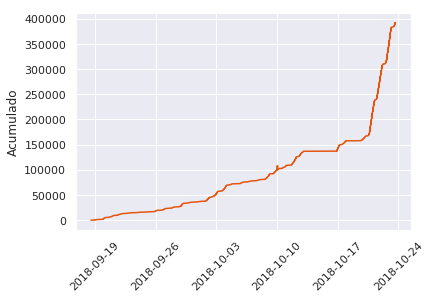

In [4]:
ax = sns.lineplot(x="times", y="Cummulative", data=allinteractions, color=gcolor)
ax.set_xlabel('')
ax.set_ylabel('Acumulado')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.savefig('report/Cummulative_progress.pdf', bbox_inches='tight')

#### Note: Cummulative progress considers all interactions since the first greeting until the student decides to end the conversation. It means, initial question (greeting), ask prefered institution, ask preferred program, ask preferred level, Brain Options, Select Options.

## 2. Frequency of interactions

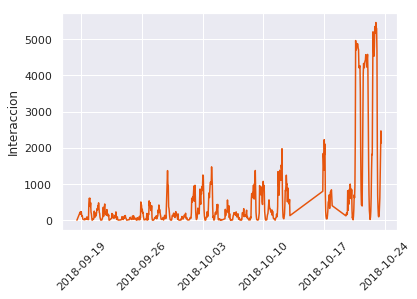

In [5]:
ax = sns.lineplot(x="hours", y="Interacted", data=allinteractions.groupby('hours').sum().reset_index(), color=gcolor)
ax.set_xlabel('')
ax.set_ylabel('Interaccion')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.savefig('report/Frequency_interactions.pdf', bbox_inches='tight')
plt.show()

#### Note: Frequency of interactions consider all interactions since the first greeting until the student decides to end the conversation. We build the graph at an hourly frequency.

## 3. Type of interaction by hour

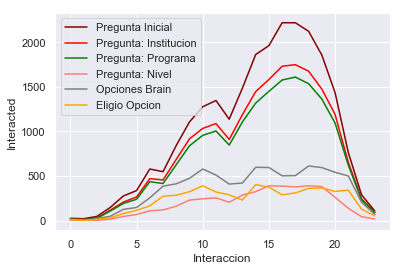

In [6]:
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'initialQuestion'].groupby('hour').sum().reset_index(), color='maroon', label='Pregunta Inicial')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askInstitution'].groupby('hour').sum().reset_index(), color='red', label='Pregunta: Institucion')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askCareer'].groupby('hour').sum().reset_index(), color='green', label='Pregunta: Programa')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askLevel'].groupby('hour').sum().reset_index(), color='salmon', label='Pregunta: Nivel')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'OPTIONS'].groupby('hour').sum().reset_index(), color='gray', label='Opciones Brain')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'OPTIONS_SELECTION'].groupby('hour').sum().reset_index(), color='orange', label='Eligio Opcion')
ax.set_xlabel('Interaccion')
plt.savefig('report/Interaction_type.pdf', bbox_inches='tight')
plt.show()

#### Note: This graph decomposes the total number of interactions by hour in a day [1 - 24] into the different types of interaction.

## 4. Wage deviation from true value by day

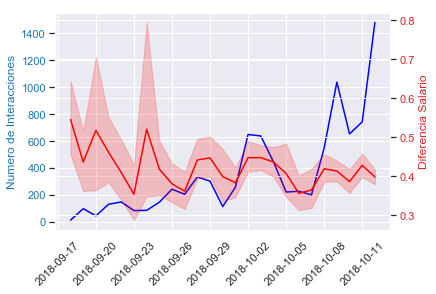

In [4]:
last_date = list(set(wageDeviation['days']))
last_date.sort()
last_date = str(last_date[-1])
#Wage diferential by day
fig, ax1 = plt.subplots()
ax = sns.lineplot(x="days", y="interaction", data=wageDeviation[wageDeviation['days']<last_date].groupby(['days']).sum().reset_index(), color='blue')
ax.set_xlabel('')
ax.set_ylabel('Numero de Interacciones', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = sns.lineplot(x="days", y="absWageDeviation", data=wageDeviation[wageDeviation['days']<last_date], color='red')
ax2.set_ylabel('Diferencia Salario', color='tab:red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='tab:red')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.savefig('report/Wage_deviation_byday.pdf', bbox_inches='tight')
plt.show()

#### Note: The number of observations consider the ammount of students that ran throught the first wage gues, and also the gues of the wage for the selected option. The averages are computed at the day level.

## 5. Wage deviation from true value (treated before vs treated today)

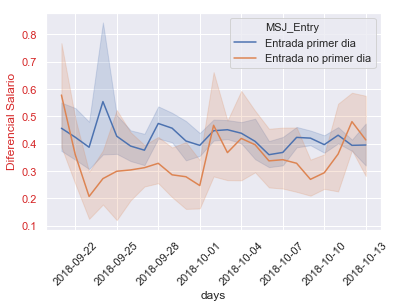

In [8]:
wageDeviation_first = (wageDeviation.merge(wageDeviation.sort_values(by=['user','times'])
                                           .groupby(['user'])
                                           .first().reset_index()[['user','days']]
                                           , left_on = ['user','days']
                                           , right_on = ['user','days']
                                           , how='left'
                                           , indicator = True))
wageDeviation_first['MSJ_Entry'] = ''
wageDeviation_first['MSJ_Entry'][wageDeviation_first['_merge']=='both'] = 'Entrada primer dia'
wageDeviation_first['MSJ_Entry'][wageDeviation_first['_merge']=='left_only'] = 'Entrada no primer dia'

fig, ax1 = plt.subplots()
ax1 = sns.lineplot(x="days", y="absWageDeviation", hue = 'MSJ_Entry', data=wageDeviation_first[wageDeviation['days']>'2018-09-20'], color='red')
ax1.set_ylabel('Diferencial Salario', color='tab:red')  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor='tab:red')
for tick in ax1.get_xticklabels(): tick.set_rotation(45)
plt.savefig('report/Wage_deviation_by_entry.pdf', bbox_inches='tight')
plt.show()

#### Note: The number of observations consider the ammount of students that ran throught the first wage gues, and also the gues of the wage for the selected option. 'First day entry' only considers students in their first day of interaction, meanwhile 'Non first day entry' considers students that interacted with the chatbot days before.  

## 6. Wage deviation from true value by number of menu interaction

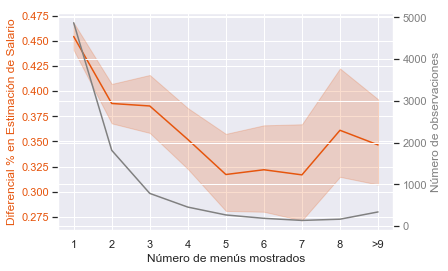

In [18]:
fig, ax = plt.subplots()
ax = sns.lineplot(x="numberMenu", y="absWageDeviation", data=wageDeviation[wageDeviation['days']<last_date], color=gcolor)
ax.set_xlabel('Número de menús mostrados')
ax.set_ylabel('Diferencial % en Estimación de Salario', color=gcolor)
ax.tick_params(axis='y', labelcolor=gcolor)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = sns.lineplot(x="numberMenu", y="N_total", data=wageDeviation[wageDeviation['days']<last_date].groupby(['numberMenu']).sum().reset_index(), color='gray')
#plt.ylabel('Número de observaciones', color='tab:gray')  # we already handled the x-label with ax1
ax2.set_ylabel('Número de observaciones', color='gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')
labels = [int(x) for x in ax.get_xticks().tolist()]
labels[-2]='>9'
ax.set_xticklabels(labels)
plt.savefig('report/Wage_deviation_by_nint.pdf', bbox_inches='tight')
plt.show()

#### Note: Averages are computed at number of interaction level. The ammount of observations are the interactions that ran throught the first wage gues to the last interaction gues of the wage for the selected option. 

## 7. Wage deviation decomposition by number of interaction.

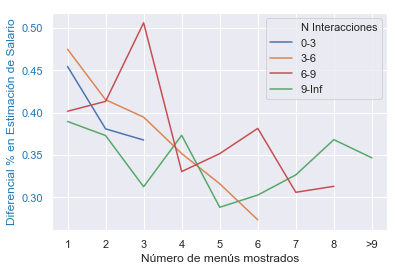

In [48]:
fig, ax = plt.subplots()
ax = sns.lineplot(x="numberMenu", y="absWageDeviation", hue='Max_interaction',err_style="bars", ci=0, data=wageDeviation[wageDeviation['days']<last_date], color=gcolor)
ax.set_xlabel('Número de menús mostrados')
ax.set_ylabel('Diferencial % en Estimación de Salario', color='tab:blue')
plt.legend([ax.get_legend_handles_labels()[0][t] for t in [0,1,2,4,3]], ['N Interacciones','0-3', '3-6', '6-9', '9-Inf'])
ax.tick_params(axis='y', labelcolor='tab:blue')
labels = [int(x) for x in ax.get_xticks().tolist()]
labels[-2]='>9'
ax.set_xticklabels(labels)
plt.savefig('report/Wage_deviation_decomposition.pdf', bbox_inches='tight')
plt.show()

#### Note: Averages are computed at number of interaction level. The ammount of observations are the interactions that ran throught the first wage gues to the last interaction gues of the wage for the selected option. 

## 8. Chatbot intervention take-up 

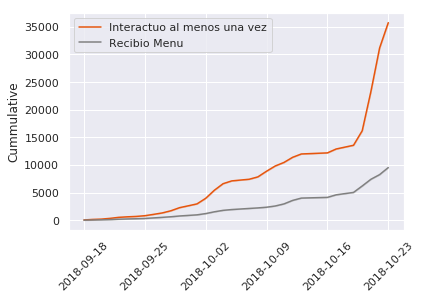

In [11]:
takeupData_Seed = seedAssignment.merge((allinteractions[['user', 'timestamp', 'days']].sort_values(by=['user','timestamp']).groupby(['user'])
                                           .first().reset_index())
                     , left_on='url_id', right_on='user', how='inner').sort_values(by=['days'])
takeupData_Seed['Cummulative'] = np.cumsum(np.ones((takeupData_Seed.shape[0],1))).astype(int)

takeupData = (allinteractions[['user', 'timestamp', 'days']].sort_values(by=['user','timestamp']).groupby(['user'])
                                           .first().reset_index().sort_values(by=['days']))
takeupData['Cummulative'] = np.cumsum(np.ones((takeupData.shape[0],1))).astype(int)

fig, ax1 = plt.subplots()
ax = sns.lineplot(x="days", y="Cummulative", data=takeupData, color=gcolor, label='Interactuo al menos una vez')
ax2 = sns.lineplot(x="days", y="Cummulative", data=takeupData_Seed, color='gray', label='Recibio Menu')
ax.set_xlabel('')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.savefig('report/Takeup_levels.pdf', bbox_inches='tight')
plt.show()

#### Note: Cummulative magnitudes consider students that at least interacted once with the chatbot, and those that received the menu assigned by the brain. 

## 9. Number of students assigned to each treatment

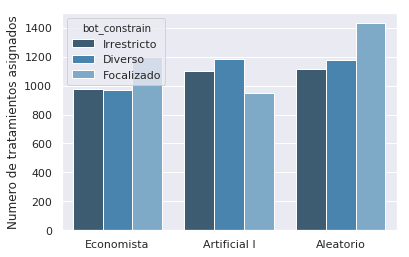

In [12]:
seedAssignment['count'] = 1

seedAssignment['bot_type']=''
seedAssignment['bot_type'][seedAssignment['bot']==11] = 'Economista'
seedAssignment['bot_type'][seedAssignment['bot']==12] = 'Economista'
seedAssignment['bot_type'][seedAssignment['bot']==13] = 'Economista'
seedAssignment['bot_type'][seedAssignment['bot']==21] = 'Artificial I'
seedAssignment['bot_type'][seedAssignment['bot']==22] = 'Artificial I'
seedAssignment['bot_type'][seedAssignment['bot']==23] = 'Artificial I'
seedAssignment['bot_type'][seedAssignment['bot']==31] = 'Aleatorio'
seedAssignment['bot_type'][seedAssignment['bot']==32] = 'Aleatorio'
seedAssignment['bot_type'][seedAssignment['bot']==33] = 'Aleatorio'

seedAssignment['bot_constrain']=''
seedAssignment['bot_constrain'][seedAssignment['bot']==11] = 'Irrestricto'
seedAssignment['bot_constrain'][seedAssignment['bot']==12] = 'Diverso'
seedAssignment['bot_constrain'][seedAssignment['bot']==13] = 'Focalizado'
seedAssignment['bot_constrain'][seedAssignment['bot']==21] = 'Irrestricto'
seedAssignment['bot_constrain'][seedAssignment['bot']==22] = 'Diverso'
seedAssignment['bot_constrain'][seedAssignment['bot']==23] = 'Focalizado'
seedAssignment['bot_constrain'][seedAssignment['bot']==31] = 'Irrestricto'
seedAssignment['bot_constrain'][seedAssignment['bot']==32] = 'Diverso'
seedAssignment['bot_constrain'][seedAssignment['bot']==33] = 'Focalizado'

ax = sns.barplot(x='bot_type', y="count", hue='bot_constrain' , data=seedAssignment.groupby(['bot', 'bot_type', 'bot_constrain']).sum().reset_index(), palette ="Blues_d", capsize=.2)
ax.set_xlabel('')
ax.set_ylabel('Numero de tratamientos asignados')
plt.savefig('report/Treatments_assigned.pdf', bbox_inches='tight')
plt.show()



#### Note: The total number of observations are the number of students that received one of the treatment arms. Ec, ML and Ra refer to the economist, machine learning, and random chatbots, meanwhile U, D and T refer to the unrestricted, diverse and targeted versions.

## 10. Number of outside option clicks

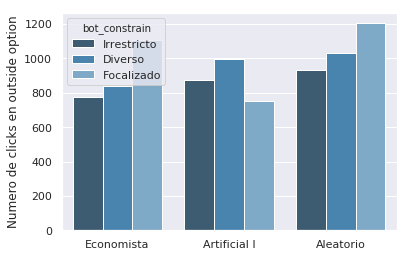

In [13]:
interactions['outsideOption'] = (interactions['Selection'] == -999)

interactions['bot_type']=''
interactions['bot_type'][interactions['bot']==11] = 'Economista'
interactions['bot_type'][interactions['bot']==12] = 'Economista'
interactions['bot_type'][interactions['bot']==13] = 'Economista'
interactions['bot_type'][interactions['bot']==21] = 'Artificial I'
interactions['bot_type'][interactions['bot']==22] = 'Artificial I'
interactions['bot_type'][interactions['bot']==23] = 'Artificial I'
interactions['bot_type'][interactions['bot']==31] = 'Aleatorio'
interactions['bot_type'][interactions['bot']==32] = 'Aleatorio'
interactions['bot_type'][interactions['bot']==33] = 'Aleatorio'

interactions['bot_constrain']=''
interactions['bot_constrain'][interactions['bot']==11] = 'Irrestricto'
interactions['bot_constrain'][interactions['bot']==12] = 'Diverso'
interactions['bot_constrain'][interactions['bot']==13] = 'Focalizado'
interactions['bot_constrain'][interactions['bot']==21] = 'Irrestricto'
interactions['bot_constrain'][interactions['bot']==22] = 'Diverso'
interactions['bot_constrain'][interactions['bot']==23] = 'Focalizado'
interactions['bot_constrain'][interactions['bot']==31] = 'Irrestricto'
interactions['bot_constrain'][interactions['bot']==32] = 'Diverso'
interactions['bot_constrain'][interactions['bot']==33] = 'Focalizado'

ax = sns.barplot(x='bot_type', y="outsideOption", hue='bot_constrain' , data=interactions.groupby(['bot', 'bot_type', 'bot_constrain']).sum().reset_index(), palette ='Blues_d', capsize=.2)
#ax = sns.barplot(x="bot", y="outsideOption", data=interactions.groupby(['bot']).sum().reset_index(), capsize=.2)
ax.set_xlabel('')
ax.set_ylabel('Numero de clicks en outside option')
plt.savefig('report/Outside_option_clicks.pdf', bbox_inches='tight')
plt.show()

#### Note: The total number of observations are the number of outside options selections. Ec, ML and Ra refer to the economist, machine learning, and random chatbots, meanwhile U, D and T refer to the unrestricted, diverse and targeted versions.

## 11. Percentage of outside option selected

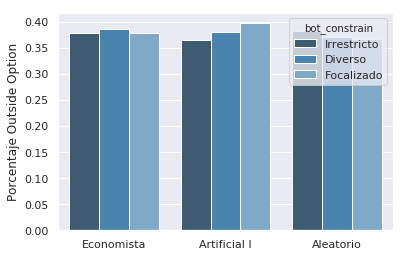

In [14]:
interactions['outsideOption'] = (interactions['Selection'] == -999)
ax = sns.barplot(x='bot_type', y="outsideOption", hue='bot_constrain' , data=interactions.groupby(['bot', 'bot_type', 'bot_constrain']).mean().reset_index(), palette ='Blues_d', capsize=.2)
ax.set_xlabel('')
ax.set_ylabel('Porcentaje Outside Option')
plt.savefig('report/outside_option_percentage.pdf', bbox_inches='tight')
plt.show()

#### Note: The total number of observations are the number of options (Menus) given to students. Ec, ML and Ra refer to the economist, machine learning, and random chatbots, meanwhile U, D and T refer to the unrestricted, diverse and targeted versions.

## 12. Number of menus shown by treatment arm:

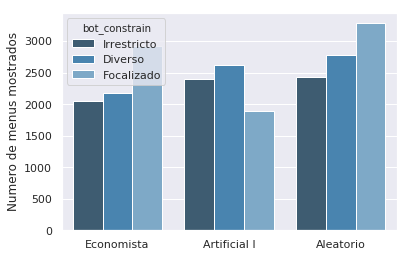

In [15]:
fig, ax = plt.subplots()
interactions['count'] = 1
ax = sns.barplot(x='bot_type', y="count", hue='bot_constrain' , data=interactions.groupby(['bot', 'bot_type', 'bot_constrain']).sum().reset_index(), palette ='Blues_d', capsize=.2)
ax.set_xlabel('')
ax.set_ylabel('Numero de menus mostrados')
plt.savefig('report/Number_menus.pdf', bbox_inches='tight')
plt.show()

#### Note: The total number of observations are the number of options (Menus) showed to students. Ec, ML and Ra refer to the economist, machine learning, and random chatbots, meanwhile U, D and T refer to the unrestricted, diverse and targeted versions.